In [141]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
def f(x):
    return 3*x**2 - 4 * x + 5

In [143]:
f(3.0)

20.0

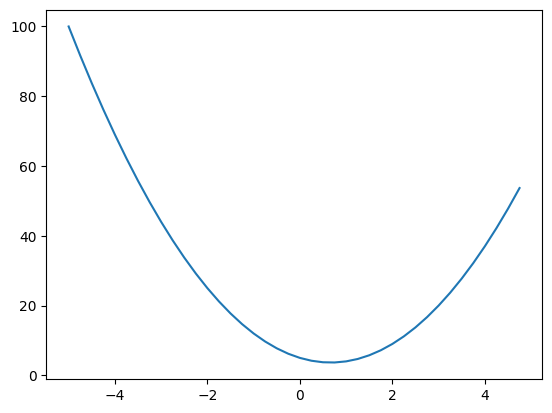

In [144]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [145]:
h = 0.001
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

In [146]:
h = 0.0001
a = 2.0; b = -3.0; c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [147]:
h = 0.0001
a = 2.0; b = -3.0; c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [148]:
h = 0.0001
a = 2.0; b = -3.0; c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [149]:
class Value:
    
    def __init__(self, data, _children=(), _op="", label = ""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
             self.grad += 1.0 * out.grad
             other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
             self.grad += other.data * out.grad
             other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f"**{other}")
        
        def backward():
            self.grad +=  other * self.data ** (other - 1) * out.grad
        out._backward = backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other **-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = np.tanh(x)
        out = Value(t, (self,), "tanh")
        
        def _backward():
             self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
a = Value(2.0, label= "a")
b = Value(-3.0, label= "b")
c = Value(10.0, label= "c")
e = a * b; e.label = "e"
d = e + c ; d.label = "d"
f = Value(-2.0, label= "f")
L = d * f; L.label = "L"; L.grad = 1.0
L

Value(data=-8.0)

In [150]:
import torch

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+ 1] ) for i in range(len(nouts))]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [151]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
n = MLP(3, [4,4,1])
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.5292655634599814),
 Value(data=0.8490024898327718),
 Value(data=0.6580967818390646),
 Value(data=0.6650552079790472)]

In [152]:
def loss_fctn(true, pred):
    return sum([(t - p) ** 2 for t, p in zip(true, pred)])

def grad_desc(model, xs, ys, iter, step):
    for _ in range(iter):
        y_pred = [model(x) for x in xs]
        loss = loss_fctn(ys, y_pred)
        for p in model.parameters():
            p.grad = 0
        loss.backward()
        
        for p in model.parameters():
            p.data += -p.grad * step
            
        print(f"Iteration {_ + 1}: Loss = {loss.data:0.3f}")
    
    print(y_pred)
grad_desc(n, xs, ys, 100, 0.01)

Iteration 1: Loss = 6.502
Iteration 2: Loss = 6.346
Iteration 3: Loss = 6.166
Iteration 4: Loss = 5.961
Iteration 5: Loss = 5.723
Iteration 6: Loss = 5.449
Iteration 7: Loss = 5.135
Iteration 8: Loss = 4.781
Iteration 9: Loss = 4.395
Iteration 10: Loss = 3.996
Iteration 11: Loss = 3.611
Iteration 12: Loss = 3.264
Iteration 13: Loss = 2.966
Iteration 14: Loss = 2.712
Iteration 15: Loss = 2.489
Iteration 16: Loss = 2.289
Iteration 17: Loss = 2.103
Iteration 18: Loss = 1.927
Iteration 19: Loss = 1.759
Iteration 20: Loss = 1.598
Iteration 21: Loss = 1.446
Iteration 22: Loss = 1.303
Iteration 23: Loss = 1.172
Iteration 24: Loss = 1.052
Iteration 25: Loss = 0.945
Iteration 26: Loss = 0.851
Iteration 27: Loss = 0.767
Iteration 28: Loss = 0.694
Iteration 29: Loss = 0.630
Iteration 30: Loss = 0.573
Iteration 31: Loss = 0.524
Iteration 32: Loss = 0.481
Iteration 33: Loss = 0.442
Iteration 34: Loss = 0.409
Iteration 35: Loss = 0.379
Iteration 36: Loss = 0.352
Iteration 37: Loss = 0.328
Iteration 